# 6. Region properties

Once you have segmented an image you usually want to gather information on the objects that you "discovered". Instead of painstakingly do this manually, skimage offers a simplified way to do this with its ```regionprops_table``` tool.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.morphology
import scipy.ndimage as ndi

Let's first create a mask of the nuclei and clean it up with morphological operations:

In [3]:
#image_stack = skimage.io.imread('images/46658_784_B12_1.tif')
image_stack = skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif')

image_nuclei = image_stack[:,:,2]#blue channel in RGB
image_signal = image_stack[:,:,1]#green channel in RGB

# filter image
image_nuclei = skimage.filters.median(image_nuclei, skimage.morphology.disk(5))

# create mask and clean-up
mask_nuclei = image_nuclei > skimage.filters.threshold_otsu(image_nuclei)
mask_nuclei = skimage.morphology.binary_closing(mask_nuclei, footprint=skimage.morphology.disk(5))
mask_nuclei = ndi.binary_fill_holes(mask_nuclei, skimage.morphology.disk(5))

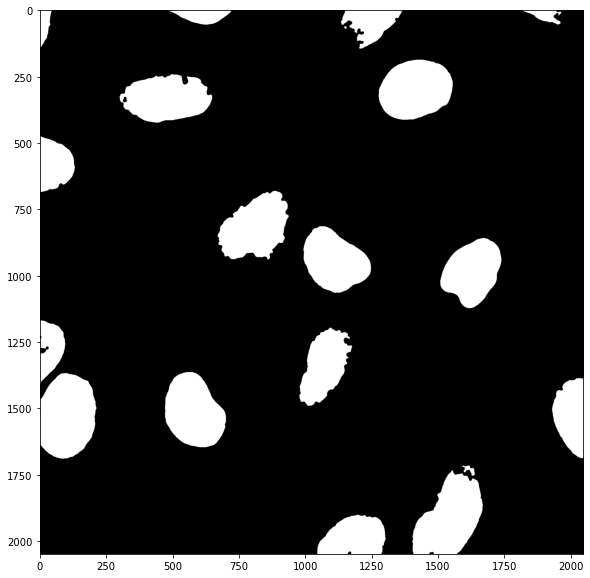

In [4]:
plt.subplots(figsize=(10,10))
plt.imshow(mask_nuclei, cmap = 'gray');

## Labelling

In order to measure objects in the image separately, we first need to label them individually. For that we can just use the ```skimage.morphology.label()``` function which looks for independent groups of white pixels and assigns them integer numbers:

In [5]:
my_labels = skimage.morphology.label(mask_nuclei)

The label map shows that numbers are assigned from top to bottom in the image:

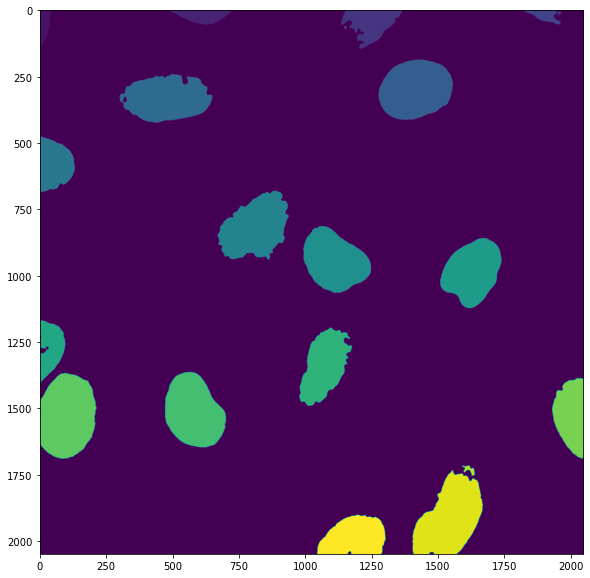

In [6]:
plt.subplots(figsize=(10,10))
plt.imshow(my_labels);

## Region properties

Now that we have each region labeled with a different number we can use the ```skimage.measure.regionprops_table()``` function, which takes such as label map and analyzes the geometric properties of each region. We have to specifiy which ```properties``` we want to use. For example the ```area``` and ```labels```:

In [7]:
my_regions = skimage.measure.regionprops_table(my_labels, properties=('label','area'))

The output is a dictionary of all properties that we asked to get out:

In [8]:
my_regions

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 'area': array([ 4221,  8386, 18258,  4043,    73, 49056, 45671, 20537, 46853,
        43277, 40768, 15090, 35404, 47642, 54978, 26774,     4,   812,
        54298, 29638])}

### Dictionaries

Until now, in terms of data structures, we have briefly seen lists ```mylist = [5, 4, 2]``` and Numpy arrays via the images. However Python offers additional types of data structures and dictionaries are one of them. As you can see in the output above, they are define with curly parentheses ```{}``` and contain pairs of elements: keys like ```label``` and ```area``` and a *content* for each key, here two Numpy arrays. To better understand let's just create a simple one:

In [9]:
my_dict = {'fruit name': 'apple', 'weigth': 50, 'types': ['golden', 'gala', 'breaburn']}
my_dict

{'fruit name': 'apple', 'weigth': 50, 'types': ['golden', 'gala', 'breaburn']}

As you can see these dictionaries can contain all types of variables: strings, numbers, lists etc. They are for this reason ideal to hold information of various types and useful to describe entities thanks to the dictionary keys. Each entry in the dictionary can then be recovered via its key:

In [10]:
my_dict['weigth']

50

## Recovering image intensity information

In what we did above, we only recovered information about our mask. However often we want to obtain information on pixel values of the **original** image. For example, "what is the average intensity of each nucleus?"

Luckily ```regionprops_table``` allows us to pass as additional argument ```intensity_image``` the image we want to use to quantify intensity. Then we can for example add as property to extract the ```mean_intensity```:

In [11]:
my_regions = skimage.measure.regionprops_table(
    my_labels,intensity_image=image_signal, properties=('label','area','mean_intensity'))

Now we have access to additional parameters. For example the mean_intensity in each nucleus:

In [12]:
my_regions

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 'area': array([ 4221,  8386, 18258,  4043,    73, 49056, 45671, 20537, 46853,
        43277, 40768, 15090, 35404, 47642, 54978, 26774,     4,   812,
        54298, 29638]),
 'mean_intensity': array([ 79.26510306,  65.99773432,  70.26109103,  63.02671284,
         47.43835616,  53.71450995,  53.8070986 ,  70.45391245,
         66.13772864,  41.4125517 ,  58.67503925,  44.19814447,
         74.77155124,  41.70190168,  35.9041071 ,  53.07787406,
        112.        , 102.9864532 ,  56.11020664,  66.28379108])}

Now that we have this information, we can of course, plot it. For example we can produce a histogram of mean nuclei intensities:

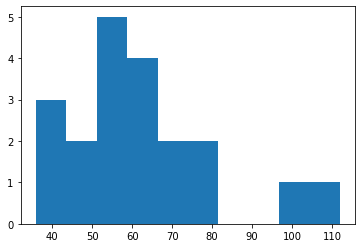

In [13]:
plt.hist(my_regions['mean_intensity']);

## Filtering information

Obviously, we had some "bad segmentations", i.e. some fragments remaining from the processing that are not actual nuclei. We can easily filter those out for example based on size using Numpy logical indexing:

In [14]:
my_regions['area']

array([ 4221,  8386, 18258,  4043,    73, 49056, 45671, 20537, 46853,
       43277, 40768, 15090, 35404, 47642, 54978, 26774,     4,   812,
       54298, 29638])

We create a logical array by setting a condition on one dictionary entry:

In [17]:
selected = my_regions['area'] > 100
selected

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True])

And then use it for logical indexing:

In [18]:
my_regions['mean_intensity'][selected]

array([ 79.26510306,  65.99773432,  70.26109103,  63.02671284,
        53.71450995,  53.8070986 ,  70.45391245,  66.13772864,
        41.4125517 ,  58.67503925,  44.19814447,  74.77155124,
        41.70190168,  35.9041071 ,  53.07787406, 102.9864532 ,
        56.11020664,  66.28379108])

## One step further: Pandas

In the above example, if we wanted to use one measurement to filter all other measurements, we would have to repeat the selection multiple times. Ideally, we would put all the measured properties into a table, one column per property, and then do typical database operations to sub-select parts of the data. This can be done using yet another data structure called a DataFrame. These structures are provided by the Pandas library, the main data science library in Python. We here give a very brief insight into that library. First we import it:

In [19]:
import pandas as pd

To understand what a DataFrame is, let's transform a plain Numpy array into a DataFrame:

In [28]:
np.random.seed(42)
my_array = np.random.randint(0,100, (3,5))
my_array

array([[51, 92, 14, 71, 60],
       [20, 82, 86, 74, 74],
       [87, 99, 23,  2, 21]])

We can simply turn this array into a DataFrame by using:

In [29]:
pd.DataFrame(my_array)

,0,1,2,3,4
0,51,92,14,71,60
1,20,82,86,74,74
2,87,99,23,2,21


We see that the array content is still there but in addition now we have column and row names, currently just indices. We could however give specific column names:

In [30]:
my_df = pd.DataFrame(my_array, columns=['a', 'b', 'c', 'd', 'e'])
my_df

,a,b,c,d,e
0,51,92,14,71,60
1,20,82,86,74,74
2,87,99,23,2,21


The difference with Numpy arrays is that DataFrames can contain different types of information (text, numbers etc.) and that they should really be seen as "organized" data. So for example we can recover a column of the table without resorting to the type of indexing we did before:

In [31]:
my_df['c']

0    14
1    86
2    23
Name: c, dtype: int64

Now how can such a structure help us do the sort of data filtering we have mentioned before? Just like with arrays, we can use some constraining tests. For example we can ask: are there data points in column ```c``` which are smaller than 50?

In [32]:
my_df['c'] < 50

0     True
1    False
2     True
Name: c, dtype: bool

Similarly to what happened with arrays, we get a new column that is boolean. And again similarly to what we did with arrays we can use it for logical indexing using square parentheses:

In [33]:
my_df[my_df['c'] < 50]

,a,b,c,d,e
0,51,92,14,71,60
2,87,99,23,2,21


What happened here is that we kept only those entries in the table where the values in the ```c``` column were smaller than 50: we filtered all the properties (columns) in our table in one go!

### Back to our problem

In our analysis we ended up with a dictionary:

In [34]:
my_regions

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 'area': array([ 4221,  8386, 18258,  4043,    73, 49056, 45671, 20537, 46853,
        43277, 40768, 15090, 35404, 47642, 54978, 26774,     4,   812,
        54298, 29638]),
 'mean_intensity': array([ 79.26510306,  65.99773432,  70.26109103,  63.02671284,
         47.43835616,  53.71450995,  53.8070986 ,  70.45391245,
         66.13772864,  41.4125517 ,  58.67503925,  44.19814447,
         74.77155124,  41.70190168,  35.9041071 ,  53.07787406,
        112.        , 102.9864532 ,  56.11020664,  66.28379108])}

We can also easily turn this dictionary into a DataFrame:

In [36]:
my_regions_df = pd.DataFrame(my_regions)
my_regions_df

,label,area,mean_intensity
0,1,4221,79.265103
1,2,8386,65.997734
2,3,18258,70.261091
3,4,4043,63.026713
4,5,73,47.438356
5,6,49056,53.714510
6,7,45671,53.807099
7,8,20537,70.453912
8,9,46853,66.137729
9,10,43277,41.412552


And now we can use what we have just learned: let's remove tiny regions with an area smaller than 100:

In [38]:
my_regions_df[my_regions_df['area'] > 100]

,label,area,mean_intensity
0,1,4221,79.265103
1,2,8386,65.997734
2,3,18258,70.261091
3,4,4043,63.026713
5,6,49056,53.714510
6,7,45671,53.807099
7,8,20537,70.453912
8,9,46853,66.137729
9,10,43277,41.412552
10,11,40768,58.675039


We see that we indeed removed to elements in that table, indices 4 and 16.

Pandas is a very powerful library and in this course we can't offer more than this brief insight into how it can be useful for data post-processing. To learn more you can also visit this other course: https://guiwitz.github.io/DAVPy/Readme.html